# Drones surveillance

A fleet of drones must be used to supervise an area. 
The area has a rectangular shape and can be discretized as a set of points to supervise.

The following plot is an example of a drone supervising a part of the area:
the dots are the spot we want to supervise, the red ones are the supervised ones, and the blue circle is the area covered by the drone camera. The goal is to maximize the supervised area.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

def draw_grid(canvas, w, h, coord):
    canvas.set_facecolor('#7AAE74')
    canvas.set_ylim([0,h])
    canvas.set_xlim([0,w])
    canvas.set_xticks(range(0,w,1))
    canvas.set_yticks(range(0,h,1))
    canvas.grid()
    grid_dots = list(itertools.product(range(0, w+1), range(0, h+1)))
    canvas.scatter([c[0] for c in grid_dots],[c[1] for c in grid_dots], color='#000000', zorder=0)
    canvas.scatter([c[0] for c in coord],[c[1] for c in coord], color='#820D10', zorder=2)

def draw_drone(canvas, x, y, radius):
    canvas.add_artist(plt.Circle((x,y), radius, zorder=1, color='#516C88'))

    
def draw_map(width, height, supervised_dots, drones):
    plt.figure(figsize=(6,6))
    gc = plt.gcf().gca()
    draw_grid(gc, width, height, supervised_dots)
    for x, y, r in drones:
        draw_drone(gc, x, y, r)
    plt.show()

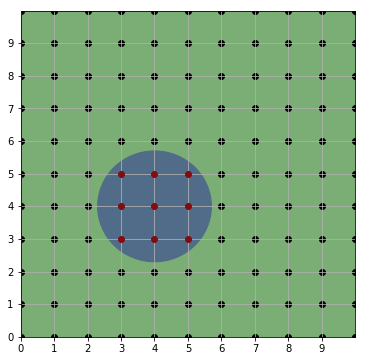

In [2]:
draw_map(10, 10, [(3,3),(3,4),(3,5),(4,3),(4,4),(4,5),(5,3),(5,4),(5,5)], [(4, 4, 1.7)])

## Data

$D:$ set of available drones  
$n,m:$ sizes of the area (in dots)  
$M = \{(i,j) : 0 \le i \le n, 0 \le j \le m, \}: $ set of coordinates of the area  
$r_d:$ surveillance radius of drone $d \in D$  
$\delta(p_1, p_2):$ function computing the euclidean distance between two dots


## variables

$x_{dp}:$ $1$ if drone $d$ is placed in coordinate $p$, $0$ otherwise  
$y_{p}:$ $1$ if coordinate $p$ is supervised, $0$ otherwise  

## Objective function

Maximize the supervised area (in terms of supervised dots)
$$z^* = \max \sum_{p \in M} y_{p}$$

## Constraints

Each drone cannot be placed in two different coordinates
$$ \sum_{p \in M} x_{dp} \le 1, \forall {d \in D}$$

Each dot is supervised only if it is within the radius of at least one drone
$$ y_{p} \le \sum_{d \in D} \sum_{q \in M : \delta(p, q ) \le r_d } x_{dq}, \forall p \in M$$

## Model implementation

Import Pyomo and create the abstrat model:

In [3]:
import pyomo.environ as pyopt

model = pyopt.AbstractModel()

### Data - Coordinates system

In this example the sizes of the area are chosen arbitrarily, then the set $M$ of coordinates is created as their cross product:

In [4]:
m = 15
n = 15

model.m = pyopt.Set(initialize=range(m))
model.n = pyopt.Set(initialize=range(n))
model.M = model.m * model.n

### Data - Set of drones

We then create a set $D$ of $6$ drones of random radius $r$:

In [5]:
import random
random.seed(0)

drones = range(6)
model.D = pyopt.Set(initialize=drones)
model.r = pyopt.Param(model.D, rule=lambda _: random.randrange(2,4))

### Variables 

All variables are binary:  
$x_{dp}:$ $1$ if drone $d$ is placed in coordinate $p$, $0$ otherwise  
$y_{p}:$ $1$ if coordinate $p$ is supervised, $0$ otherwise  

In [6]:
model.x = pyopt.Var(model.D, model.M, within=pyopt.Binary)
model.y = pyopt.Var(model.M, within=pyopt.Binary)

### Objective function

$$z^* = \max \sum_{p \in M} y_{p}$$

The objective function maximizes the number of supervised dots:

In [7]:
def objective_function(model):
    return pyopt.sum(model.y[i,j] for (i,j) in model.M)

model.z = pyopt.Objective(sense=pyopt.maximize, rule=objective_function)

### Constraints 

Constraints `cons_covering` impose that a dot is supervised only if it is within the radius of a drone
$$ y_{p} \le \sum_{d \in D} \sum_{q \in M : \delta(p, q ) \le r_d } x_{dq}, \forall p \in M,$$
while constraints `cons_assignment` avoid to place a drone more than once:
$$ \sum_{p \in M} x_{dp} \le 1, \forall {d \in D}$$


In [8]:
import math
def delta(x1,y1,x2,y2):
    return math.sqrt( math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2) )

def cons_covering(model, i, j):
    return model.y[i,j] <= pyopt.sum(model.x[d,p,q] 
                                     for d in model.D for (p,q) in model.M 
                                     if delta(i,j,p,q) <= model.r[d] )

model.cons_covering = pyopt.Constraint(model.M, rule=cons_covering)

def cons_assignment(model, d):
    return pyopt.sum(model.x[d,i,j] for (i,j) in model.M) <= 1

model.cons_assignment = pyopt.Constraint(model.D, rule=cons_assignment)

## Solving the model

We create the instance (populating data) and run the solving process:

In [9]:
instance = model.create_instance()
solver = pyopt.SolverFactory('glpk')
results = solver.solve(instance)
print(results)


Problem: 
- Name: unknown
  Lower bound: 155.0
  Upper bound: 155.0
  Number of objectives: 1
  Number of constraints: 232
  Number of variables: 1576
  Number of nonzeros: 31610
  Sense: maximize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 623
      Number of created subproblems: 623
  Error rc: 0
  Time: 22.230950355529785
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



We can display the value of the solution and also the statistics:

In [10]:
print("Supervised area: {:.0f} dots".format(pyopt.value(instance.z)))
print("Percentage: {:.1%}".format( pyopt.value(instance.z) / len(instance.M) ))
print("Status of the solver: {}".format(results.Solver.Termination_condition))

Supervised area: 155 dots
Percentage: 68.9%
Status of the solver: optimal


And plot the resulting map

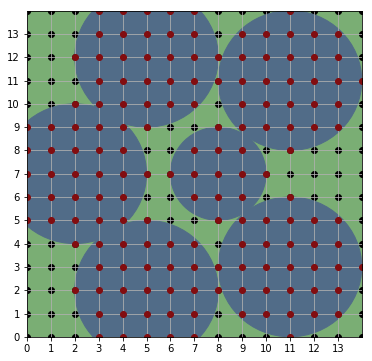

In [11]:
covered_dots = [(i,j) for (i,j), v in instance.y.iteritems() if v.value > 0]
drones = [(i, j, instance.r[d]) for (d, i, j), v in instance.x.iteritems() if v.value > 0]
draw_map(m-1, n-1, covered_dots, drones)